**Load Necessary Librariesabs**

In [1]:
import os
import nibabel as nib
import numpy as np
import gzip
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence
import random
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
import os
from scipy.ndimage import binary_erosion, binary_dilation, label, gaussian_filter
import nibabel as nib
import SimpleITK as sitk
from scipy import ndimage
from skimage import morphology
import matplotlib.pyplot as plt
import zipfile
import os
import numpy as np
import SimpleITK as sitk
from pathlib import Path
import random

**Mount Dataset Directory**

In [2]:
ct_directory = '/kaggle/input/brain-scan/label_192/images'  
gt_directory = '/kaggle/input/brain-scan/label_192/ground truths'  
output_directory = '/kaggle/working/output_directory'  
os.makedirs('/kaggle/working/patches', exist_ok=True)
os.makedirs(output_directory, exist_ok=True)

**Train-Test Split**

In [3]:
# Create necessary directories
os.makedirs(output_directory, exist_ok=True)
train_ct_dir = os.path.join(output_directory, 'train_ct')
train_gt_dir = os.path.join(output_directory, 'train_gt')
test_ct_dir = os.path.join(output_directory, 'test_ct')
test_gt_dir = os.path.join(output_directory, 'test_gt')

for dir_path in [train_ct_dir, train_gt_dir, test_ct_dir, test_gt_dir]:
    os.makedirs(dir_path, exist_ok=True)

# List all files in the CT and ground truth directories
ct_files = sorted([f for f in os.listdir(ct_directory) if os.path.isfile(os.path.join(ct_directory, f))])
gt_files = sorted([f for f in os.listdir(gt_directory) if os.path.isfile(os.path.join(gt_directory, f))])

# Ensure the number of CT files matches the number of ground truth files
assert len(ct_files) == len(gt_files), "Mismatch between the number of CT and ground truth files."

# Split into train and test sets (80-20 split)
train_ct, test_ct, train_gt, test_gt = train_test_split(ct_files, gt_files, test_size=0.2, random_state=42)

# Function to copy files
def copy_files(files, src_dir, dst_dir):
    for file in files:
        shutil.copy(os.path.join(src_dir, file), os.path.join(dst_dir, file))

# Copy CT and ground truth files to respective train and test directories
copy_files(train_ct, ct_directory, train_ct_dir)
copy_files(train_gt, gt_directory, train_gt_dir)
copy_files(test_ct, ct_directory, test_ct_dir)
copy_files(test_gt, gt_directory, test_gt_dir)

print(f"Dataset split and organized successfully!")
#print(f"Train CT: {len(train_ct)}, Train GT: {len(train_gt)}")
#print(f"Test CT: {len(test_ct)}, Test GT: {len(test_gt)}")


Dataset split and organized successfully!


In [4]:
def load_image(file_path):
    """Load a medical image and return as numpy array."""
    return sitk.GetArrayFromImage(sitk.ReadImage(file_path))

def save_patch(patch, output_path):
    """Save a patch as .nii.gz file."""
    img = sitk.GetImageFromArray(patch)
    sitk.WriteImage(img, output_path)

def validate_hemorrhage_patch(gt_patch, min_hemorrhage_percentage=0.10):
    """
    Validate if the patch contains sufficient hemorrhage pixels with stricter criteria.
    """
    hemorrhage_percentage = np.sum(gt_patch > 0) / gt_patch.size
    
    # Check if hemorrhage is well-distributed (not just at edges)
    center_region = gt_patch[gt_patch.shape[0]//4:3*gt_patch.shape[0]//4,
                           gt_patch.shape[1]//4:3*gt_patch.shape[1]//4,
                           gt_patch.shape[2]//4:3*gt_patch.shape[2]//4]
    center_percentage = np.sum(center_region > 0) / center_region.size
    
    return hemorrhage_percentage >= min_hemorrhage_percentage and center_percentage > 0.05

def extract_patches(ct_path, gt_path, output_base_dir, patch_size=(16, 32, 32), patches_per_class=100):
    """Extract balanced patches with improved validation."""
    # Create output directories
    ct_output_dir = os.path.join(output_base_dir, 'patches', 'CT')
    gt_output_dir = os.path.join(output_base_dir, 'patches', 'GT')
    os.makedirs(ct_output_dir, exist_ok=True)
    os.makedirs(gt_output_dir, exist_ok=True)

    # Load and normalize CT image
    ct_img = load_image(ct_path)
    ct_img = np.clip(ct_img, -100, 200)  # Window for better brain tissue contrast
    ct_img = (ct_img - ct_img.min()) / (ct_img.max() - ct_img.min())
    
    gt_img = load_image(gt_path)

    # Get dimensions
    depth, height, width = ct_img.shape
    d, h, w = patch_size

    if depth < d or height < h or width < w:
        print(f"Warning: Image {Path(ct_path).name} is too small for patch size {patch_size}")
        print(f"Image size: {ct_img.shape}")
        return

    # Convert multi-class to binary
    gt_binary = (gt_img > 0).astype(np.uint8)

    # Calculate valid ranges
    valid_z_range = depth - d + 1
    valid_y_range = height - h + 1
    valid_x_range = width - w + 1

    # Find hemorrhage patches with center focus
    hemorrhage_positions = []
    stride = max(1, min(valid_z_range, valid_y_range, valid_x_range) // 20)  # Smaller stride
    
    # First pass: find all potential hemorrhage centers
    for z in range(0, valid_z_range, stride):
        for y in range(0, valid_y_range, stride):
            for x in range(0, valid_x_range, stride):
                patch = gt_binary[z:z+d, y:y+h, x:x+w]
                if validate_hemorrhage_patch(patch):
                    # Calculate hemorrhage centroid in this patch
                    coords = np.where(patch > 0)
                    if len(coords[0]) > 0:
                        center_z = z + int(np.mean(coords[0]))
                        center_y = y + int(np.mean(coords[1]))
                        center_x = x + int(np.mean(coords[2]))
                        
                        # Adjust position to center the hemorrhage
                        new_z = max(0, min(valid_z_range - 1, center_z - d//2))
                        new_y = max(0, min(valid_y_range - 1, center_y - h//2))
                        new_x = max(0, min(valid_x_range - 1, center_x - w//2))
                        
                        hemorrhage_positions.append((new_z, new_y, new_x))

    # Find normal patches away from hemorrhage regions
    normal_positions = []
    max_attempts = 2000  # Increased attempts
    attempts = 0
    
    # Create hemorrhage distance map for better normal patch selection
    hemorrhage_mask = np.zeros_like(gt_binary)
    for z, y, x in hemorrhage_positions:
        hemorrhage_mask[z:z+d, y:y+h, x:x+w] = 1

    while len(normal_positions) < patches_per_class and attempts < max_attempts:
        z = random.randint(0, valid_z_range - 1)
        y = random.randint(0, valid_y_range - 1)
        x = random.randint(0, valid_x_range - 1)
        
        # Check if patch is far from hemorrhage regions
        if np.sum(hemorrhage_mask[z:z+d, y:y+h, x:x+w]) == 0:
            patch = gt_binary[z:z+d, y:y+h, x:x+w]
            if np.sum(patch) == 0:
                normal_positions.append((z, y, x))
        attempts += 1

    if len(hemorrhage_positions) == 0:
        print(f"Warning: No hemorrhage patches found in {Path(ct_path).name}")
        return

    # Sample positions
    num_hemorrhage_patches = min(patches_per_class, len(hemorrhage_positions))
    num_normal_patches = min(patches_per_class, len(normal_positions))
    
    hemorrhage_samples = random.sample(hemorrhage_positions, num_hemorrhage_patches)
    normal_samples = random.sample(normal_positions, num_normal_patches)

    #print(f"Found {len(hemorrhage_positions)} hemorrhage positions and {len(normal_positions)} normal positions")
    print(f"Extracting {num_hemorrhage_patches} hemorrhage patches and {num_normal_patches} normal patches")

    # Extract and save patches
    for class_name, positions in [('hemorrhage', hemorrhage_samples), ('normal', normal_samples)]:
        for idx, pos in enumerate(positions):
            z, y, x = pos
            
            # Extract patches
            ct_patch = ct_img[z:z+d, y:y+h, x:x+w]
            gt_patch = gt_binary[z:z+d, y:y+h, x:x+w]

            # Additional validation for hemorrhage patches
            if class_name == 'hemorrhage' and not validate_hemorrhage_patch(gt_patch):
                continue

            # Generate filenames
            base_filename = f"{Path(ct_path).stem}_{class_name}_{idx}"
            ct_output_path = os.path.join(ct_output_dir, f"{base_filename}.nii.gz")
            gt_output_path = os.path.join(gt_output_dir, f"{base_filename}.nii.gz")

            # Save patches
            save_patch(ct_patch, ct_output_path)
            save_patch(gt_patch, gt_output_path)

def process_all_images(ct_directory, gt_directory, output_directory, patches_per_class=50):
    """Process all images in the specified directories."""
    ct_files = [f for f in os.listdir(ct_directory) if f.endswith('.nii')]
    gt_files = [f for f in os.listdir(gt_directory) if f.endswith('.nii')]
    
    for ct_file, gt_file in zip(ct_files, gt_files):
        print(f"Processing {ct_file}")
        ct_path = os.path.join(ct_directory, ct_file)
        gt_path = os.path.join(gt_directory, gt_file)
        
        extract_patches(
            ct_path=ct_path,
            gt_path=gt_path,
            output_base_dir=output_directory,
            patches_per_class=patches_per_class
        )
        print(f"Completed {ct_file}")

# Define directories
ct_directory = '/kaggle/working/output_directory/train_ct'  # CT images directory
gt_directory = '/kaggle/working/output_directory/train_gt'  # Ground Truth directory
output_directory = '/kaggle/working'  # Output directory

# Process all images
process_all_images(ct_directory, gt_directory, output_directory, patches_per_class=50)


Processing ID_98450f26_ID_8d66ffdc94.nii
Completed ID_98450f26_ID_8d66ffdc94.nii
Processing ID_2872834a_ID_542e9d00da.nii
Extracting 50 hemorrhage patches and 50 normal patches
Completed ID_2872834a_ID_542e9d00da.nii
Processing ID_181aab15_ID_062634d043.nii
Extracting 50 hemorrhage patches and 50 normal patches
Completed ID_181aab15_ID_062634d043.nii
Processing ID_a1703be5_ID_d0e02f0443.nii
Extracting 50 hemorrhage patches and 50 normal patches
Completed ID_a1703be5_ID_d0e02f0443.nii
Processing ID_58d2ebfa_ID_76487f508f.nii
Extracting 50 hemorrhage patches and 50 normal patches
Completed ID_58d2ebfa_ID_76487f508f.nii
Processing ID_9631ec18_ID_c205d02b10.nii
Extracting 50 hemorrhage patches and 50 normal patches
Completed ID_9631ec18_ID_c205d02b10.nii
Processing ID_346de481_ID_2e8fea0d9a.nii
Extracting 50 hemorrhage patches and 50 normal patches
Completed ID_346de481_ID_2e8fea0d9a.nii
Processing ID_0c6b97a9_ID_6011bb9ce8.nii
Extracting 50 hemorrhage patches and 50 normal patches
Complet

In [5]:
def count_files_by_class(directory):

    normal_count = 0
    hemorrhage_count = 0
    
    for filename in os.listdir(directory):
        if "normal" in filename.lower():
            normal_count += 1
        elif "hemorrhage" in filename.lower():
            hemorrhage_count += 1
    
    return {"normal": normal_count, "hemorrhage": hemorrhage_count}

# Paths to CT and GT directories
ct_dir = '/kaggle/working/patches/CT'
gt_dir = '/kaggle/working/patches/GT'

# Count files in CT directory
ct_counts = count_files_by_class(ct_dir)
print(f"CT Directory - Normal: {ct_counts['normal']}, Hemorrhage: {ct_counts['hemorrhage']}")

# Count files in GT directory
gt_counts = count_files_by_class(gt_dir)
print(f"GT Directory - Normal: {gt_counts['normal']}, Hemorrhage: {gt_counts['hemorrhage']}")


CT Directory - Normal: 3750, Hemorrhage: 3744
GT Directory - Normal: 3750, Hemorrhage: 3744


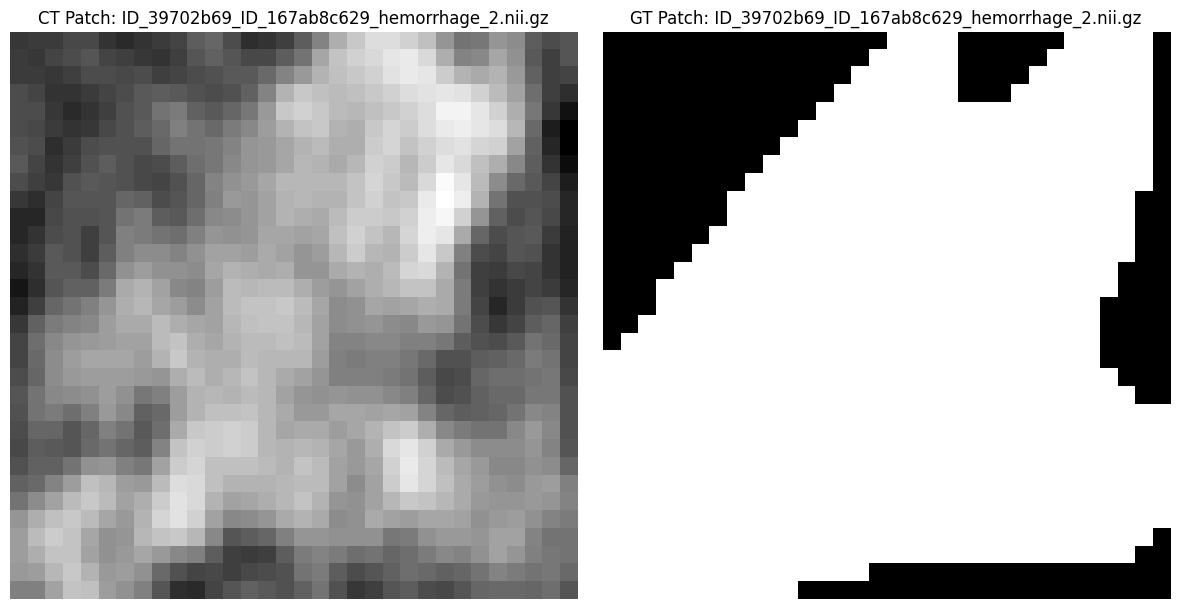

In [10]:
import os
import random
import SimpleITK as sitk
import matplotlib.pyplot as plt

def load_image(file_path):

    return sitk.GetArrayFromImage(sitk.ReadImage(file_path))

def visualize_random_hemorrhage_patches(ct_dir, gt_dir, num_patches=2):

    # Get all hemorrhage files
    ct_files = [f for f in os.listdir(ct_dir) if "hemorrhage" in f.lower()]
    gt_files = [f for f in os.listdir(gt_dir) if "hemorrhage" in f.lower()]
    
    # Ensure the number of files matches between CT and GT directories
    assert len(ct_files) == len(gt_files), "Mismatch between CT and GT hemorrhage files."
    
    # Select random files
    selected_files = random.sample(ct_files, min(num_patches, len(ct_files)))
    
    # Visualize patches
    for file in selected_files:
        ct_path = os.path.join(ct_dir, file)
        gt_path = os.path.join(gt_dir, file)
        
        # Load CT and GT patches
        ct_patch = load_image(ct_path)
        gt_patch = load_image(gt_path)
        
        # Plot the patches
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(ct_patch[ct_patch.shape[0] // 2], cmap="gray")  # Show middle slice
        axes[0].set_title(f"CT Patch: {file}")
        axes[0].axis("off")
        
        axes[1].imshow(gt_patch[gt_patch.shape[0] // 2], cmap="gray")  # Show middle slice
        axes[1].set_title(f"GT Patch: {file}")
        axes[1].axis("off")
        
        plt.tight_layout()
        plt.show()

# Paths to CT and GT directories
ct_dir = '/kaggle/working/patches/CT'
gt_dir = '/kaggle/working/patches/GT'

# Visualize random hemorrhage patches
visualize_random_hemorrhage_patches(ct_dir, gt_dir, num_patches=1)


In [4]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Binary Cross-Entropy (built-in)
binary_crossentropy = tf.keras.losses.BinaryCrossentropy()

# Dice Coefficient
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)  # Ensure type compatibility
    y_pred = tf.cast(y_pred, tf.float32)  # Ensure type compatibility
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    # Apply threshold to the predictions (binarize)
    y_pred_f = K.cast(K.greater_equal(y_pred_f, 0.5), tf.float32)  # Convert prob to 0 or 1

    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Dice Loss (optional if needed as a loss function)
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

# Precision
def precision(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Ensure type compatibility
    y_pred = tf.cast(y_pred, tf.float32)  # Ensure type compatibility
    
    # Apply threshold to the predictions (binarize)
    y_pred_f = K.cast(K.greater_equal(y_pred, 0.5), tf.float32)

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred_f)
    
    true_positives = K.sum(y_true_f * y_pred_f)
    predicted_positives = K.sum(y_pred_f)
    
    return true_positives / (predicted_positives + K.epsilon())

# Recall
def recall(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Ensure type compatibility
    y_pred = tf.cast(y_pred, tf.float32)  # Ensure type compatibility
    
    # Apply threshold to the predictions (binarize)
    y_pred_f = K.cast(K.greater_equal(y_pred, 0.5), tf.float32)

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred_f)
    
    true_positives = K.sum(y_true_f * y_pred_f)
    possible_positives = K.sum(y_true_f)
    
    return true_positives / (possible_positives + K.epsilon())


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def create_3d_unet(input_shape=(16, 32, 32, 1)):
    # Add batch normalization and dropout for better regularization
    inputs = tf.keras.Input(shape=input_shape)
    
    # Encoder - with improved regularization and efficiency
    c1 = layers.Conv3D(32, (3, 3, 3), kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)
    c1 = layers.Conv3D(32, (3, 3, 3), kernel_initializer='he_normal', padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)
    p1 = layers.MaxPooling3D((2, 2, 2))(c1)
    p1 = layers.Dropout(0.2)(p1)

    c2 = layers.Conv3D(64, (3, 3, 3), kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)
    c2 = layers.Conv3D(64, (3, 3, 3), kernel_initializer='he_normal', padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)
    p2 = layers.MaxPooling3D((2, 2, 2))(c2)
    p2 = layers.Dropout(0.3)(p2)

    c3 = layers.Conv3D(128, (3, 3, 3), kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)
    c3 = layers.Conv3D(128, (3, 3, 3), kernel_initializer='he_normal', padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)
    p3 = layers.MaxPooling3D((2, 2, 2))(c3)
    p3 = layers.Dropout(0.4)(p3)

    # Bottleneck - with improved feature extraction
    c4 = layers.Conv3D(256, (3, 3, 3), kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Activation('relu')(c4)
    c4 = layers.Conv3D(256, (3, 3, 3), kernel_initializer='he_normal', padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Activation('relu')(c4)
    c4 = layers.Dropout(0.5)(c4)

    # Decoder - with improved upsampling and skip connections
    u5 = layers.Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), kernel_initializer='he_normal', padding='same')(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv3D(128, (3, 3, 3), kernel_initializer='he_normal', padding='same')(u5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Activation('relu')(c5)
    c5 = layers.Conv3D(128, (3, 3, 3), kernel_initializer='he_normal', padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Activation('relu')(c5)
    c5 = layers.Dropout(0.4)(c5)

    u6 = layers.Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), kernel_initializer='he_normal', padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv3D(64, (3, 3, 3), kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Activation('relu')(c6)
    c6 = layers.Conv3D(64, (3, 3, 3), kernel_initializer='he_normal', padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Activation('relu')(c6)
    c6 = layers.Dropout(0.3)(c6)

    u7 = layers.Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), kernel_initializer='he_normal', padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv3D(32, (3, 3, 3), kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Activation('relu')(c7)
    c7 = layers.Conv3D(32, (3, 3, 3), kernel_initializer='he_normal', padding='same')(c7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Activation('relu')(c7)
    c7 = layers.Dropout(0.2)(c7)

    outputs = layers.Conv3D(1, (1, 1, 1), activation='sigmoid')(c7)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    # Use mixed precision for better performance on compatible GPUs
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=binary_crossentropy,
        metrics=[
            'accuracy',
            dice_coefficient,
            precision,
            recall
        ]
    )
    
    return model

# Specify the input shape based on your patch size
input_shape = (16, 32, 32, 1)
# Build the model
unet_model = create_3d_unet(input_shape=input_shape)

# Summary of the model
unet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 16, 32, 32, 1)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d (Conv3D)           │ (None, 16, 32, 32, 32) │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 16, 32, 32, 32) │            128 │ conv3d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 16, 32, 32, 32) │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_1 (Conv3D)         │ (None, 16, 32, 32, 32) │         27,680 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 16, 32, 32, 32) │            128 │ conv3d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 16, 32, 32, 32) │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d             │ (None, 8, 16, 16, 32)  │              0 │ activation_1[0][0]     │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 8, 16, 16, 32)  │              0 │ max_pooling3d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_2 (Conv3D)         │ (None, 8, 16, 16, 64)  │         55,360 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 8, 16, 16, 64)  │            256 │ conv3d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 8, 16, 16, 64)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_3 (Conv3D)         │ (None, 8, 16, 16, 64)  │        110,656 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 8, 16, 16, 64)  │            256 │ conv3d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 8, 16, 16, 64)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_1           │ (None, 4, 8, 8, 64)    │              0 │ activation_3[0][0]     │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)  

 Total params: 5,605,345 (21.38 MB)

 Trainable params: 5,602,529 (21.37 MB)

 Non-trainable params: 2,816 (11.00 KB)

Training data shape: (5995, 16, 32, 32, 1), (5995, 16, 32, 32, 1)
Validation data shape: (1499, 16, 32, 32, 1), (1499, 16, 32, 32, 1)
Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.7857 - dice_coefficient: 0.4048 - loss: 0.4699 - precision: 0.3095 - recall: 0.6161
Epoch 1: val_dice_coefficient improved from -inf to 0.35141, saving model to /kaggle/working/output_directory/best_3d_unet_model.keras
94/94 ━━━━━━━━━━━━━━━━━━━━ 87s 616ms/step - accuracy: 0.7864 - dice_coefficient: 0.4060 - loss: 0.4691 - precision: 0.3108 - recall: 0.6168 - val_accuracy: 0.6729 - val_dice_coefficient: 0.3514 - val_loss: 0.8605 - val_precision: 0.2223 - val_recall: 0.8452 - learning_rate: 1.0000e-04
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9344 - dice_coefficient: 0.6834 - loss: 0.2683 - precision: 0.6919 - recall: 0.6827
Epoch 2: val_dice_coefficient improved from 0.35141 to 0.46574, saving model to /kaggle/working/output_directory/best_3d_unet_model.keras
94/94 ━

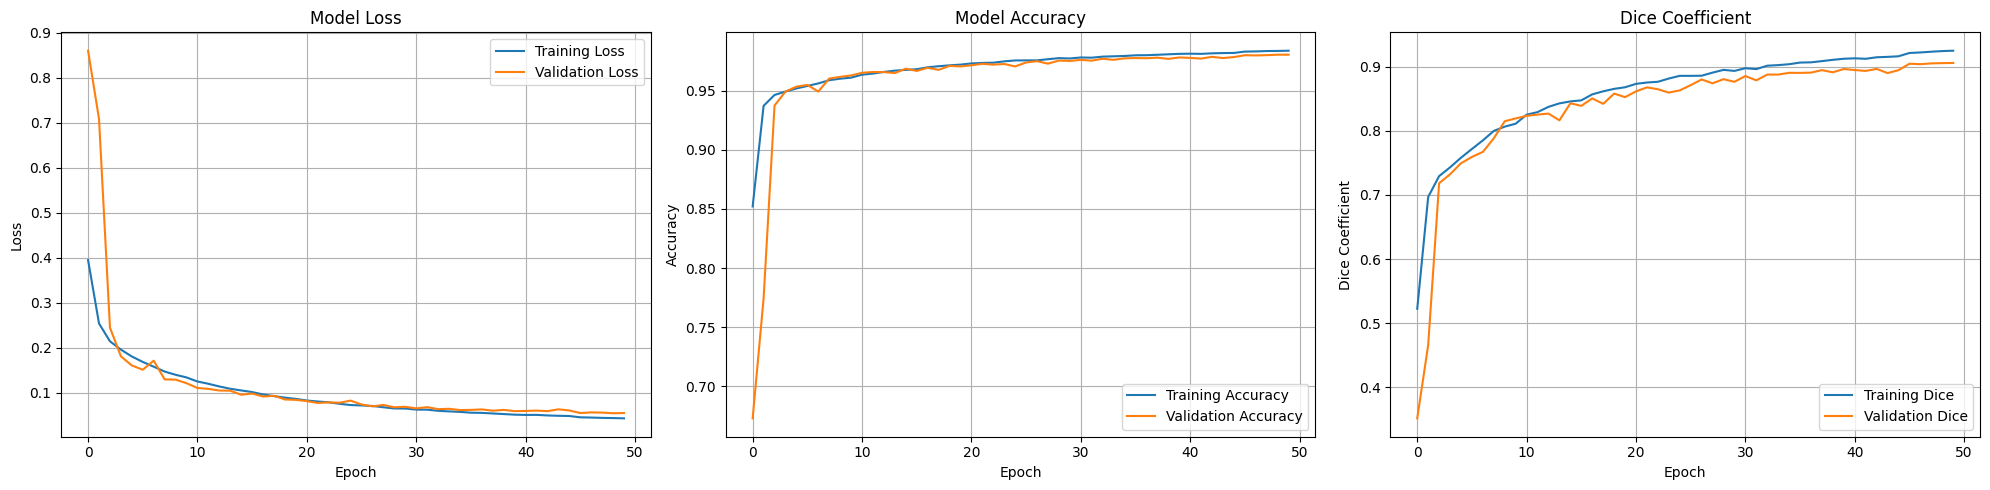


Best Validation Metrics:
Dice Coefficient: 0.9059
Accuracy: 0.9805
Loss: 0.0546


In [14]:
import os
import numpy as np
import SimpleITK as sitk
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Directories for train CT and GT patches
train_ct_dir = '/kaggle/working/patches/CT'
train_gt_dir = '/kaggle/working/patches/GT'

# Function to load patches
def load_patches(ct_dir, gt_dir):
    ct_files = sorted([os.path.join(ct_dir, f) for f in os.listdir(ct_dir) if f.endswith('.nii.gz')])
    gt_files = sorted([os.path.join(gt_dir, f) for f in os.listdir(gt_dir) if f.endswith('.nii.gz')])

    ct_patches = []
    gt_patches = []

    for ct_file, gt_file in zip(ct_files, gt_files):
        # Load the CT and GT patches
        ct_patch = sitk.GetArrayFromImage(sitk.ReadImage(ct_file)).astype(np.float32)
        gt_patch = sitk.GetArrayFromImage(sitk.ReadImage(gt_file)).astype(np.uint8)
        
        # Ensure ground truth is binary
        gt_patch = (gt_patch > 0).astype(np.uint8)

        ct_patches.append(ct_patch)
        gt_patches.append(gt_patch)

    return np.array(ct_patches), np.array(gt_patches)
def plot_training_history(history):
    """
    Plot training history including loss, accuracy, and Dice coefficient
    """
    # Create a figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    
    # Plot training & validation loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='upper right')
    ax1.grid(True)
    
    # Plot training & validation accuracy
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='lower right')
    ax2.grid(True)
    
    # Plot training & validation Dice coefficient
    ax3.plot(history.history['dice_coefficient'], label='Training Dice')
    ax3.plot(history.history['val_dice_coefficient'], label='Validation Dice')
    ax3.set_title('Dice Coefficient')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Dice Coefficient')
    ax3.legend(loc='lower right')
    ax3.grid(True)
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/output_directory/training_history.png')
    plt.show()
    
    # Print best metrics
    best_val_dice = max(history.history['val_dice_coefficient'])
    best_val_acc = max(history.history['val_accuracy'])
    best_val_loss = min(history.history['val_loss'])
    
    print("\nBest Validation Metrics:")
    print(f"Dice Coefficient: {best_val_dice:.4f}")
    print(f"Accuracy: {best_val_acc:.4f}")
    print(f"Loss: {best_val_loss:.4f}")
# Load all patches
ct_patches, gt_patches = load_patches(train_ct_dir, train_gt_dir)

# Reshape patches to add channel dimension
ct_patches = np.expand_dims(ct_patches, axis=-1) 
gt_patches = np.expand_dims(gt_patches, axis=-1)  

# Split into training and validation sets
ct_train, ct_val, gt_train, gt_val = train_test_split(ct_patches, gt_patches, test_size=0.2, random_state=42)
ct_train = tf.cast(ct_train, tf.float32)
ct_val = tf.cast(ct_val, tf.float32)
gt_train = tf.cast(gt_train, tf.float32)
gt_val = tf.cast(gt_val, tf.float32)
print(f"Training data shape: {ct_train.shape}, {gt_train.shape}")
print(f"Validation data shape: {ct_val.shape}, {gt_val.shape}")

# Callbacks
callbacks = [
    ModelCheckpoint(
        filepath='/kaggle/working/output_directory/best_3d_unet_model.keras',  
        save_best_only=True,
        monitor='val_dice_coefficient',  
        mode='max',  
        verbose=1
    ),
    EarlyStopping(
        monitor='val_dice_coefficient',  
        patience=7,  
        mode='max',  
        verbose=1,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',  
        factor=0.5,  
        patience=5,  
        verbose=1
    )
]

# Train the model
history = unet_model.fit(
    x=ct_train,
    y=gt_train,
    validation_data=(ct_val, gt_val),
    batch_size=64,  
    epochs=50,     
    callbacks=callbacks,
    verbose=1
)

# Plot training history
plot_training_history(history)

# Save the final model
unet_model.save('/kaggle/working/output_directory/final_3d_unet_model.keras')

# Save history to a numpy file for later analysis if needed
np.save('/kaggle/working/output_directory/training_history.npy', history.history)

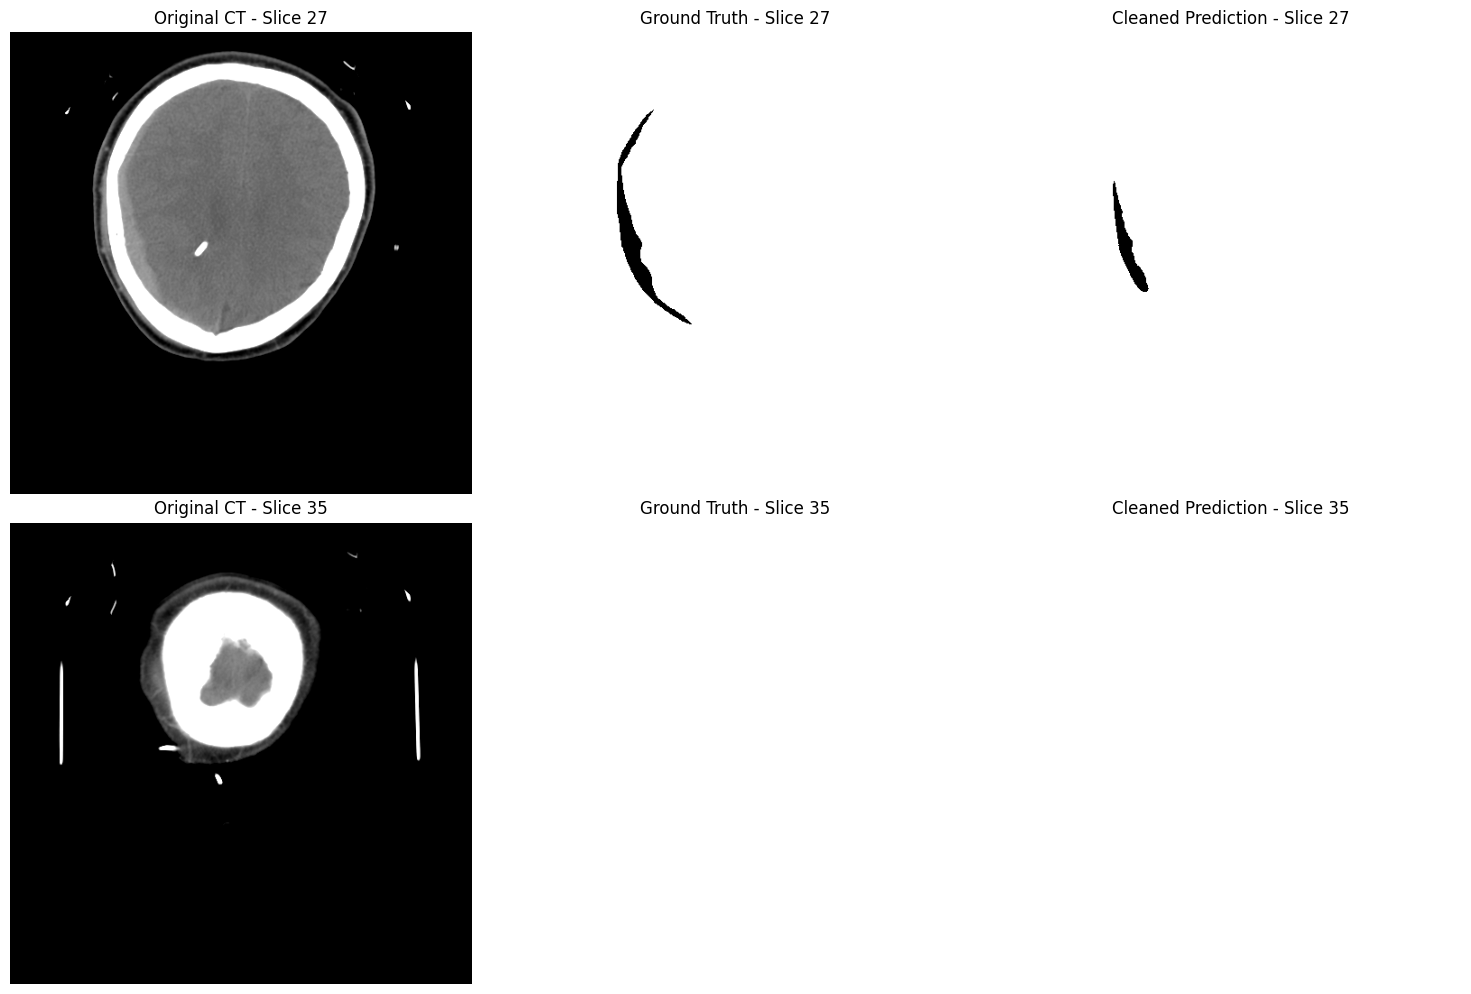

Visualized slices [27, 35] from the random file ID_9a8ad2df_ID_0ec627c99a.nii


In [8]:
import os
import random
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from scipy import ndimage
from tensorflow.keras.models import load_model

def load_and_preprocess_image(file_path):
    """Load and preprocess a CT image."""
    # Load image
    img = sitk.GetArrayFromImage(sitk.ReadImage(file_path))
    
    # Apply same preprocessing as training
    img = np.clip(img, -100, 200)  # Window for better brain tissue contrast
    img = (img - img.min()) / (img.max() - img.min())
    
    return img

def post_process_prediction(prediction, min_size=50):
    """Post-process the binary prediction to remove small components."""
    # Convert to binary
    binary_pred = prediction > 0.5
    
    # Label connected components
    labeled_array, num_features = ndimage.label(binary_pred)
    
    # Calculate size of each component
    component_sizes = np.bincount(labeled_array.ravel())
    
    # Create mask of components to keep
    too_small = component_sizes < min_size
    too_small[0] = False  # Don't remove background
    mask = too_small[labeled_array]
    
    # Remove small components
    binary_pred[mask] = False
    
    # Apply morphological closing to smooth boundaries
    binary_pred = ndimage.binary_closing(binary_pred)
    
    return binary_pred.astype(np.uint8)

def predict_patches(model, image, patch_size=(16, 32, 32)):
    """Predict on overlapping patches and reconstruct full image."""
    depth, height, width = image.shape
    d, h, w = patch_size

    # Initialize prediction and weight volumes
    prediction = np.zeros_like(image, dtype=np.float32)
    weight_map = np.zeros_like(image, dtype=np.float32)

    # Calculate stride (50% overlap)
    stride_d = d // 2
    stride_h = h // 2
    stride_w = w // 2

    # Gaussian weighting for smoother transitions
    gauss_d = np.hanning(d)[:, None, None]
    gauss_h = np.hanning(h)[None, :, None]
    gauss_w = np.hanning(w)[None, None, :]
    gauss = gauss_d * gauss_h * gauss_w  # Shape will be (d, h, w)

    # Iterate over the image with overlapping patches
    for z in range(0, depth - d + 1, stride_d):
        for y in range(0, height - h + 1, stride_h):
            for x in range(0, width - w + 1, stride_w):
                # Extract patch
                patch = image[z:z+d, y:y+h, x:x+w]
                
                # Add channel dimension
                patch = np.expand_dims(np.expand_dims(patch, axis=0), axis=-1)

                # Predict
                pred = model.predict(patch, verbose=0)[0, ..., 0]

                # Add weighted prediction to output
                prediction[z:z+d, y:y+h, x:x+w] += pred * gauss
                weight_map[z:z+d, y:y+h, x:x+w] += gauss

    # Avoid division by zero in normalization
    weight_map = np.maximum(weight_map, 1e-7)

    # Normalize predictions by weight map
    prediction /= weight_map

    # Apply post-processing
    cleaned_prediction = post_process_prediction(prediction)

    return cleaned_prediction

# Load model
model = load_model('/kaggle/input/best-3d-ResUnet-model/bests_3d_unet_model.keras', 
                   custom_objects={
                       'dice_coefficient': dice_coefficient,
                       'precision': precision,
                       'recall': recall,
                       'binary_crossentropy': binary_crossentropy
                   })

# Define test directories
test_ct_dir = '/kaggle/working/output_directory/test_ct/'
test_gt_dir = '/kaggle/working/output_directory/test_gt/'

# Select a random test file
random_ct_file = random.choice(os.listdir(test_ct_dir))
ct_path = os.path.join(test_ct_dir, random_ct_file)
gt_path = os.path.join(test_gt_dir, random_ct_file)

# Load and preprocess test image
ct_image = load_and_preprocess_image(ct_path)
gt_image = sitk.GetArrayFromImage(sitk.ReadImage(gt_path))
gt_image = (gt_image > 0).astype(np.uint8)

# Generate prediction with post-processing
prediction_binary = predict_patches(model, ct_image)

# Randomly select slices for visualization
total_slices = ct_image.shape[0]
slices_to_show = random.sample(range(total_slices), 2)

# Visualize random slices
plt.figure(figsize=(15, 10))

for i, slice_idx in enumerate(slices_to_show):
    plt.subplot(2, 3, i*3+1)
    plt.imshow(ct_image[slice_idx], cmap='gray')
    plt.title(f'Original CT - Slice {slice_idx}')
    plt.axis('off')

    plt.subplot(2, 3, i*3+2)
    plt.imshow(gt_image[slice_idx], cmap='binary')
    plt.title(f'Ground Truth - Slice {slice_idx}')
    plt.axis('off')

    plt.subplot(2, 3, i*3+3)
    plt.imshow(prediction_binary[slice_idx], cmap='binary')
    plt.title(f'Cleaned Prediction - Slice {slice_idx}')
    plt.axis('off')

plt.tight_layout()
plt.savefig('/kaggle/working/random_cleaned_comparison_result.png')
plt.show()

print(f"Visualized slices {slices_to_show} from the random file {random_ct_file}")


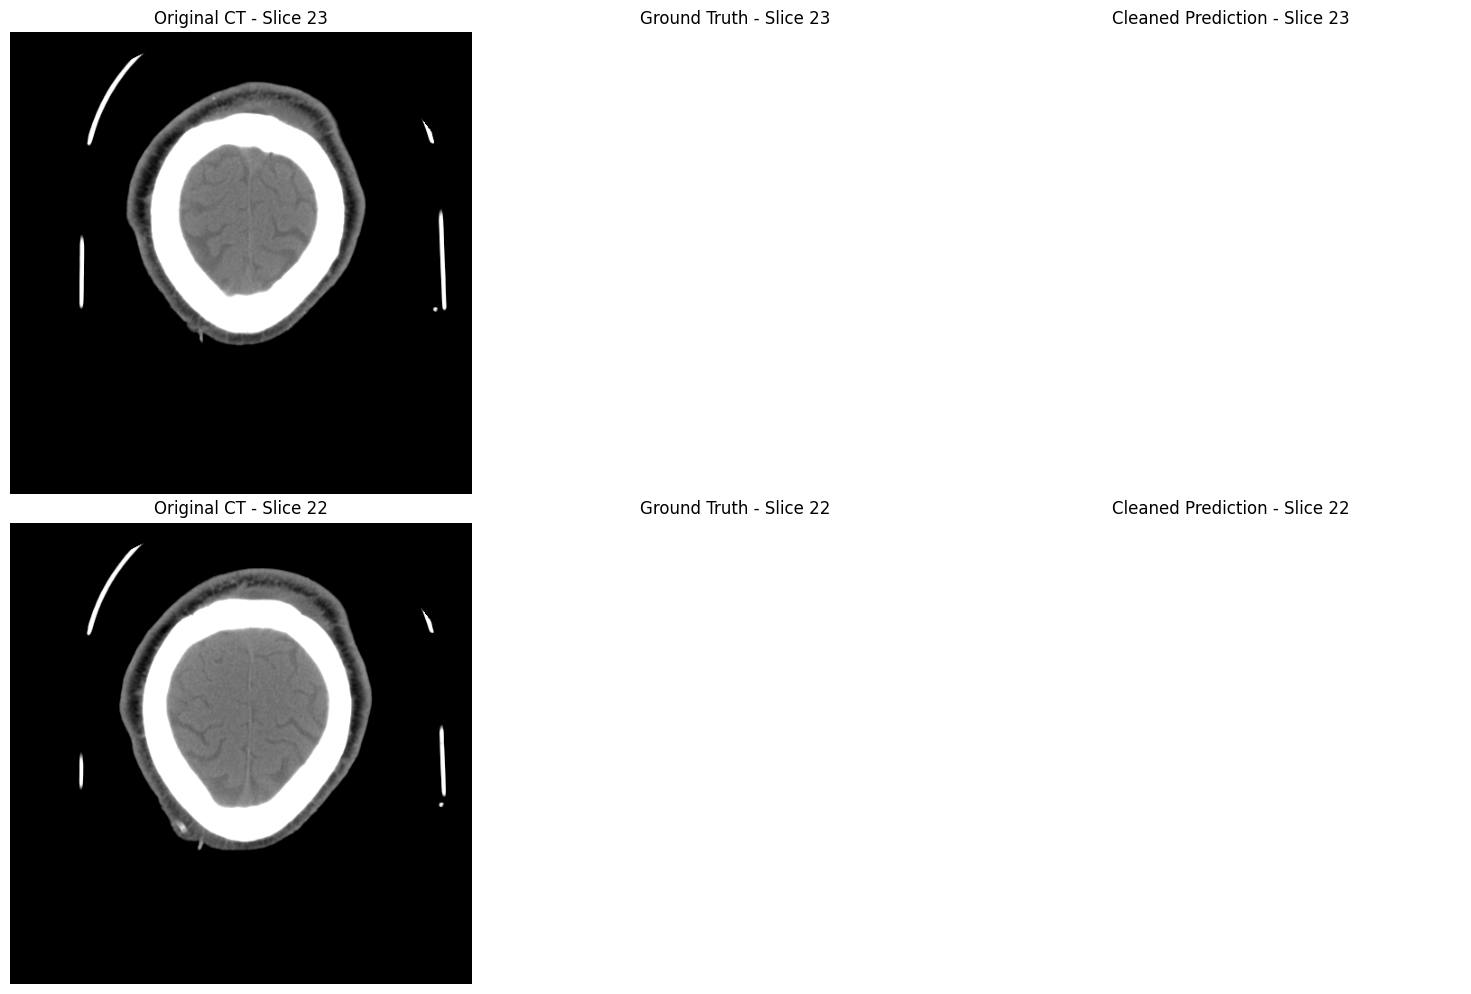

Visualized slices [23, 22] from the random file ID_d3d99dce_ID_cd10b6aba1.nii


In [10]:
import os
import random
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from scipy import ndimage
from tensorflow.keras.models import load_model

def load_and_preprocess_image(file_path):
    """Load and preprocess a CT image."""
    # Load image
    img = sitk.GetArrayFromImage(sitk.ReadImage(file_path))
    
    # Apply same preprocessing as training
    img = np.clip(img, -100, 200)  # Window for better brain tissue contrast
    img = (img - img.min()) / (img.max() - img.min())
    
    return img

def post_process_prediction(prediction, min_size=50):
    """Post-process the binary prediction to remove small components."""
    # Convert to binary
    binary_pred = prediction > 0.5
    
    # Label connected components
    labeled_array, num_features = ndimage.label(binary_pred)
    
    # Calculate size of each component
    component_sizes = np.bincount(labeled_array.ravel())
    
    # Create mask of components to keep
    too_small = component_sizes < min_size
    too_small[0] = False  # Don't remove background
    mask = too_small[labeled_array]
    
    # Remove small components
    binary_pred[mask] = False
    
    # Apply morphological closing to smooth boundaries
    binary_pred = ndimage.binary_closing(binary_pred)
    
    return binary_pred.astype(np.uint8)

def predict_patches(model, image, patch_size=(16, 32, 32)):
    """Predict on overlapping patches and reconstruct full image."""
    depth, height, width = image.shape
    d, h, w = patch_size

    # Initialize prediction and weight volumes
    prediction = np.zeros_like(image, dtype=np.float32)
    weight_map = np.zeros_like(image, dtype=np.float32)

    # Calculate stride (50% overlap)
    stride_d = d // 2
    stride_h = h // 2
    stride_w = w // 2

    # Gaussian weighting for smoother transitions
    gauss_d = np.hanning(d)[:, None, None]
    gauss_h = np.hanning(h)[None, :, None]
    gauss_w = np.hanning(w)[None, None, :]
    gauss = gauss_d * gauss_h * gauss_w  # Shape will be (d, h, w)

    # Iterate over the image with overlapping patches
    for z in range(0, depth - d + 1, stride_d):
        for y in range(0, height - h + 1, stride_h):
            for x in range(0, width - w + 1, stride_w):
                # Extract patch
                patch = image[z:z+d, y:y+h, x:x+w]
                
                # Add channel dimension
                patch = np.expand_dims(np.expand_dims(patch, axis=0), axis=-1)

                # Predict
                pred = model.predict(patch, verbose=0)[0, ..., 0]

                # Add weighted prediction to output
                prediction[z:z+d, y:y+h, x:x+w] += pred * gauss
                weight_map[z:z+d, y:y+h, x:x+w] += gauss

    # Avoid division by zero in normalization
    weight_map = np.maximum(weight_map, 1e-7)

    # Normalize predictions by weight map
    prediction /= weight_map

    # Apply post-processing
    cleaned_prediction = post_process_prediction(prediction)

    return cleaned_prediction

# Load model
model = load_model('/kaggle/input/best-3d-unet-model/bests_3d_unet_model.keras', 
                   custom_objects={
                       'dice_coefficient': dice_coefficient,
                       'precision': precision,
                       'recall': recall,
                       'binary_crossentropy': binary_crossentropy
                   })

# Define test directories
test_ct_dir = '/kaggle/working/output_directory/test_ct/'
test_gt_dir = '/kaggle/working/output_directory/test_gt/'

# Select a random test file
random_ct_file = random.choice(os.listdir(test_ct_dir))
ct_path = os.path.join(test_ct_dir, random_ct_file)
gt_path = os.path.join(test_gt_dir, random_ct_file)

# Load and preprocess test image
ct_image = load_and_preprocess_image(ct_path)
gt_image = sitk.GetArrayFromImage(sitk.ReadImage(gt_path))
gt_image = (gt_image > 0).astype(np.uint8)

# Generate prediction with post-processing
prediction_binary = predict_patches(model, ct_image)

# Randomly select slices for visualization
total_slices = ct_image.shape[0]
slices_to_show = random.sample(range(total_slices), 2)

# Visualize random slices
plt.figure(figsize=(15, 10))

for i, slice_idx in enumerate(slices_to_show):
    plt.subplot(2, 3, i*3+1)
    plt.imshow(ct_image[slice_idx], cmap='gray')
    plt.title(f'Original CT - Slice {slice_idx}')
    plt.axis('off')

    plt.subplot(2, 3, i*3+2)
    plt.imshow(gt_image[slice_idx], cmap='binary')
    plt.title(f'Ground Truth - Slice {slice_idx}')
    plt.axis('off')

    plt.subplot(2, 3, i*3+3)
    plt.imshow(prediction_binary[slice_idx], cmap='binary')
    plt.title(f'Cleaned Prediction - Slice {slice_idx}')
    plt.axis('off')

plt.tight_layout()
plt.savefig('/kaggle/working/random_cleaned_comparison_result.png')
plt.show()

print(f"Visualized slices {slices_to_show} from the random file {random_ct_file}")


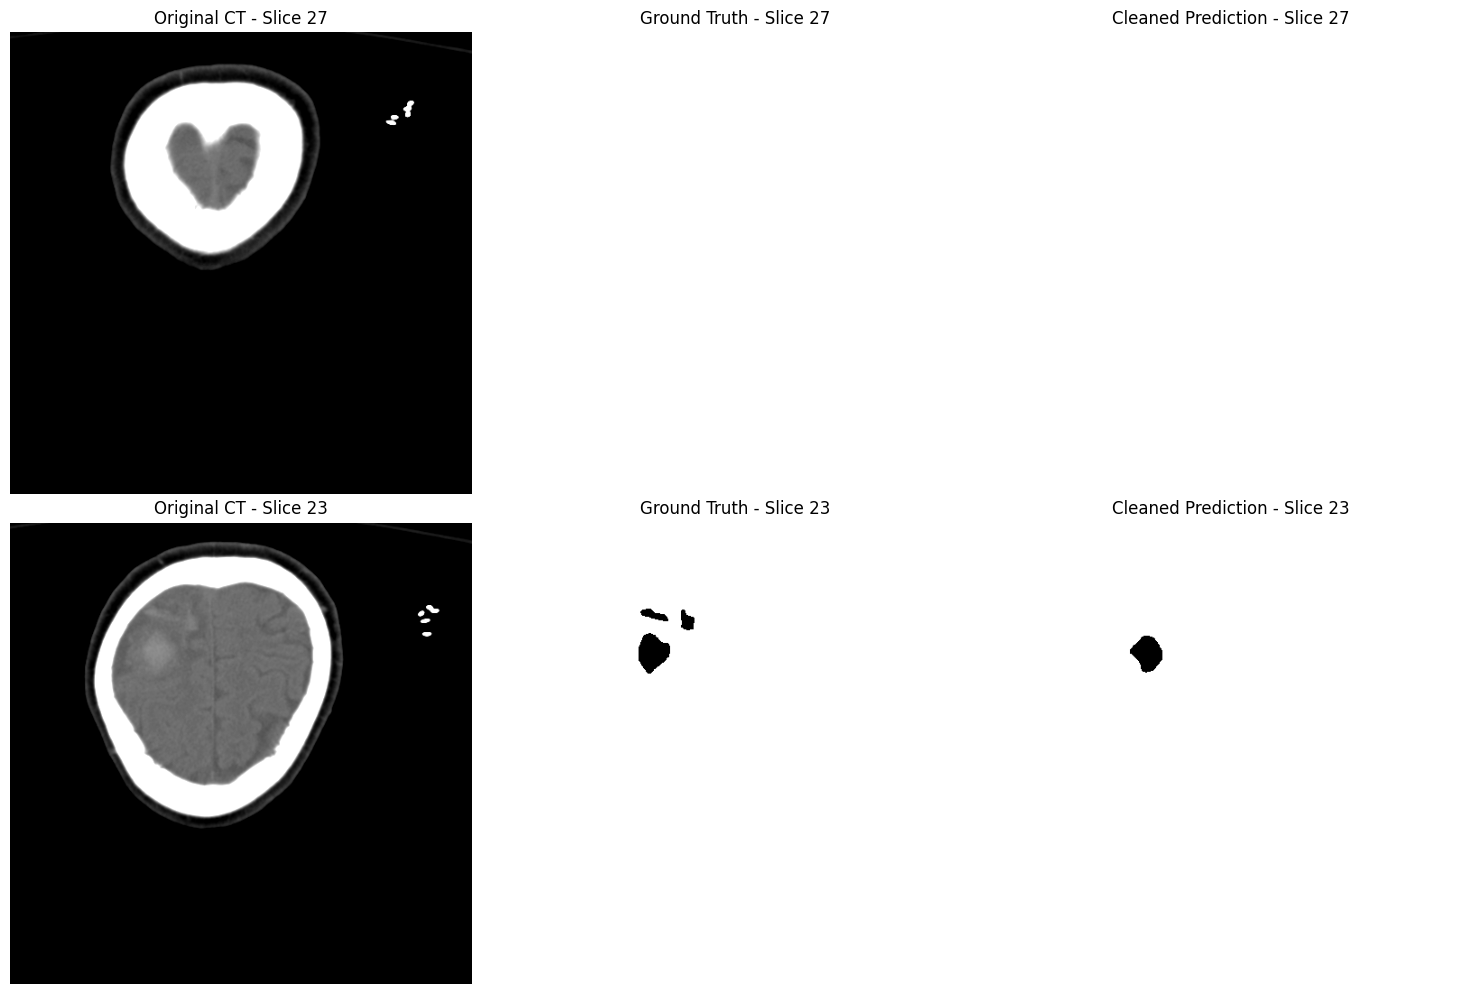

Visualized slices [27, 23] from the random file ID_b3a33085_ID_175a5c4119.nii


In [11]:
import os
import random
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from scipy import ndimage
from tensorflow.keras.models import load_model

def load_and_preprocess_image(file_path):
    """Load and preprocess a CT image."""
    # Load image
    img = sitk.GetArrayFromImage(sitk.ReadImage(file_path))
    
    # Apply same preprocessing as training
    img = np.clip(img, -100, 200)  # Window for better brain tissue contrast
    img = (img - img.min()) / (img.max() - img.min())
    
    return img

def post_process_prediction(prediction, min_size=50):
    """Post-process the binary prediction to remove small components."""
    # Convert to binary
    binary_pred = prediction > 0.5
    
    # Label connected components
    labeled_array, num_features = ndimage.label(binary_pred)
    
    # Calculate size of each component
    component_sizes = np.bincount(labeled_array.ravel())
    
    # Create mask of components to keep
    too_small = component_sizes < min_size
    too_small[0] = False  # Don't remove background
    mask = too_small[labeled_array]
    
    # Remove small components
    binary_pred[mask] = False
    
    # Apply morphological closing to smooth boundaries
    binary_pred = ndimage.binary_closing(binary_pred)
    
    return binary_pred.astype(np.uint8)

def predict_patches(model, image, patch_size=(16, 32, 32)):
    """Predict on overlapping patches and reconstruct full image."""
    depth, height, width = image.shape
    d, h, w = patch_size

    # Initialize prediction and weight volumes
    prediction = np.zeros_like(image, dtype=np.float32)
    weight_map = np.zeros_like(image, dtype=np.float32)

    # Calculate stride (50% overlap)
    stride_d = d // 2
    stride_h = h // 2
    stride_w = w // 2

    # Gaussian weighting for smoother transitions
    gauss_d = np.hanning(d)[:, None, None]
    gauss_h = np.hanning(h)[None, :, None]
    gauss_w = np.hanning(w)[None, None, :]
    gauss = gauss_d * gauss_h * gauss_w  # Shape will be (d, h, w)

    # Iterate over the image with overlapping patches
    for z in range(0, depth - d + 1, stride_d):
        for y in range(0, height - h + 1, stride_h):
            for x in range(0, width - w + 1, stride_w):
                # Extract patch
                patch = image[z:z+d, y:y+h, x:x+w]
                
                # Add channel dimension
                patch = np.expand_dims(np.expand_dims(patch, axis=0), axis=-1)

                # Predict
                pred = model.predict(patch, verbose=0)[0, ..., 0]

                # Add weighted prediction to output
                prediction[z:z+d, y:y+h, x:x+w] += pred * gauss
                weight_map[z:z+d, y:y+h, x:x+w] += gauss

    # Avoid division by zero in normalization
    weight_map = np.maximum(weight_map, 1e-7)

    # Normalize predictions by weight map
    prediction /= weight_map

    # Apply post-processing
    cleaned_prediction = post_process_prediction(prediction)

    return cleaned_prediction

# Load model
model = load_model('/kaggle/input/best-3d-unet-model/bests_3d_unet_model.keras', 
                   custom_objects={
                       'dice_coefficient': dice_coefficient,
                       'precision': precision,
                       'recall': recall,
                       'binary_crossentropy': binary_crossentropy
                   })

# Define test directories
test_ct_dir = '/kaggle/working/output_directory/test_ct/'
test_gt_dir = '/kaggle/working/output_directory/test_gt/'

# Select a random test file
random_ct_file = random.choice(os.listdir(test_ct_dir))
ct_path = os.path.join(test_ct_dir, random_ct_file)
gt_path = os.path.join(test_gt_dir, random_ct_file)

# Load and preprocess test image
ct_image = load_and_preprocess_image(ct_path)
gt_image = sitk.GetArrayFromImage(sitk.ReadImage(gt_path))
gt_image = (gt_image > 0).astype(np.uint8)

# Generate prediction with post-processing
prediction_binary = predict_patches(model, ct_image)

# Randomly select slices for visualization
total_slices = ct_image.shape[0]
slices_to_show = random.sample(range(total_slices), 2)

# Visualize random slices
plt.figure(figsize=(15, 10))

for i, slice_idx in enumerate(slices_to_show):
    plt.subplot(2, 3, i*3+1)
    plt.imshow(ct_image[slice_idx], cmap='gray')
    plt.title(f'Original CT - Slice {slice_idx}')
    plt.axis('off')

    plt.subplot(2, 3, i*3+2)
    plt.imshow(gt_image[slice_idx], cmap='binary')
    plt.title(f'Ground Truth - Slice {slice_idx}')
    plt.axis('off')

    plt.subplot(2, 3, i*3+3)
    plt.imshow(prediction_binary[slice_idx], cmap='binary')
    plt.title(f'Cleaned Prediction - Slice {slice_idx}')
    plt.axis('off')

plt.tight_layout()
plt.savefig('/kaggle/working/random_cleaned_comparison_result.png')
plt.show()

print(f"Visualized slices {slices_to_show} from the random file {random_ct_file}")
